# Explore the videos

In [1]:
!pip install git+https://github.com/tensorflow/docs
!pip install tensorflow

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8v0ayebw
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-8v0ayebw
  Resolved https://github.com/tensorflow/docs to commit a85e05593b485171c388df1a45b6da668edc39e7
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=190416 sha256=9d8fa545cccdf78aab815116c3234c3f202f25ab37a90c66ea8391364a992453
  Stored in directory: /tmp/pip-ephem-wheel-cache-7cn4mmb8/wheels/34/53/89/3db54cf97ce0f0261aaab3fdc12a847ea0879d34edf373e2c5
Successfully built tensorflow-docs


In [2]:
# tensorflow >= 2.10.0
import tensorflow as tf
print(tf.__version__)

2025-05-20 18:57:53.649708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747767473.674529   14761 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747767473.681720   14761 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [3]:
import os
import pandas as pd
from collections import defaultdict
import cv2
import numpy as np

# for animation
import imageio
from IPython import display
from urllib import request

In [4]:
from tensorflow_docs.vis import embed

In [5]:
# Load the CSV
labels_df = pd.read_csv('/kaggle/input/changing-tires/labels.csv')

action_to_label = {}
for path in labels_df['video_path']:
    folder = path.split('/')[0]
    label = labels_df[labels_df['video_path'].str.startswith(folder)].iloc[0]['label']
    action_to_label[folder] = label

video_counts = defaultdict(int)
for path in labels_df['video_path']:
    folder = path.split('/')[0]
    video_counts[folder] += 1

In [6]:

print("Action to Label Mapping:")
for action, label in action_to_label.items():
    print(f"{action}: {label}")

print("=" * 40)

print("Video Counts per Action:")
for action, count in video_counts.items():
    print(f"{action}: {count} videos")


Action to Label Mapping:
hand_tighten_bolts: 0
initial_wrench_tighten: 1
lift_car_with_jack: 2
loosen_bolts: 3
lower_car: 4
place_spare_tire: 5
remove_bolts: 6
remove_tire: 7
tighten_bolts: 8
Video Counts per Action:
hand_tighten_bolts: 100 videos
initial_wrench_tighten: 100 videos
lift_car_with_jack: 100 videos
loosen_bolts: 100 videos
lower_car: 100 videos
place_spare_tire: 100 videos
remove_bolts: 100 videos
remove_tire: 77 videos
tighten_bolts: 100 videos


# Create frames from each video file

In [7]:
import tensorflow as tf
import random
import numpy as np
import cv2
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

# Frame processing functions
def format_frames(frame, output_size=(224, 224)):
    """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result


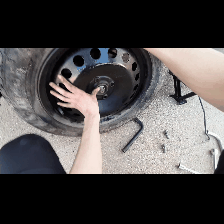

In [14]:
video_path = "/kaggle/input/changing-tires/hand_tighten_bolts/hand_tighten_bolts_13.mp4"
sample_video = frames_from_video_file(video_path, n_frames = 100)
sample_video.shape
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')
to_gif(sample_video)

# Prepare data for training

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

# Load the CSV
data_dir = Path("/kaggle/input/changing-tires")
df = pd.read_csv(data_dir / "labels.csv")

# Split into train/val DataFrames (80% train, 20% val)
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

In [26]:
print(train_df.shape)
print(val_df.shape)


(701, 2)
(176, 2)


In [27]:
class FrameGenerator:
    def __init__(self, data_dir, split_df, n_frames, training=False):
        self.data_dir = Path(data_dir)
        self.split_df = split_df  # Pass DataFrame directly
        self.n_frames = n_frames
        self.training = training
        
        # Extract video paths and labels from DataFrame
        self.video_paths = [self.data_dir / path for path in self.split_df['video_path']]
        self.labels = self.split_df['label'].tolist()
        
        # Extract class names from directory structure (using training data)
        self.class_names = self._get_class_names()

    def _get_class_names(self):
        # Extract directory names from the DataFrame's video paths
        directories = [str(path).split('/')[0] for path in self.split_df['video_path']]
        unique_dirs = sorted(
            set(directories), 
            key=lambda x: self.split_df[self.split_df['video_path'].str.contains(x)].iloc[0]['label']
        )
        return unique_dirs

    def __call__(self):
        pairs = list(zip(self.video_paths, self.labels))
        if self.training:
            random.shuffle(pairs)
        
        for path, label in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            yield video_frames, label
    

In [28]:
# Create generators
train_generator = FrameGenerator(
    data_dir=data_dir,
    split_df=train_df,
    n_frames=16,
    training=True  # Enable shuffling
)

val_generator = FrameGenerator(
    data_dir=data_dir,
    split_df=val_df,
    n_frames=16,
    training=False  # No shuffling
)


In [29]:
# Create TensorFlow datasets
output_signature = (
    tf.TensorSpec(shape=(16, None, None, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int16)
)
    
train_ds = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=output_signature
)
    
val_ds = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=output_signature
)

In [30]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(6, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)


In [31]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (16, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (16, 224, 224, 3)
Shape of validation labels: ()


# Configure the dataset for performance

Use buffered prefetching such that you can yield data from the disk without having I/O become blocking.

In [32]:
# Important: drop_remainder=True ensures fixed batch size for XLA compilation
train_ds = train_ds.batch(2, drop_remainder=True)
val_ds = val_ds.batch(2, drop_remainder=True)
    
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
# Build model with fixed input shape
input_shape = (16, 224, 224, 3)

In [34]:
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 16, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 16, 224, 224, 3)
Shape of validation labels: (2,)


In [35]:
# Create model
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Rescaling(scale=1./255))(inputs)

    
# Load EfficientNetB0 base model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

x = tf.keras.layers.TimeDistributed(base_model)(x)
x = tf.keras.layers.GlobalAveragePooling3D()(x)
outputs = tf.keras.layers.Dense(9)(x)

model = tf.keras.Model(inputs, outputs)
# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
    
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 16, 224, 224, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 16, 224, 224, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 16, 7, 7, 1280)      │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │          11,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,061,100 (15.49 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [36]:
# Train model
history = model.fit(
    train_ds, 
    epochs=10,
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
    ]
)

Epoch 1/10
    350/Unknown 960s 2s/step - accuracy: 0.1150 - loss: 2.3018

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 1193s 3s/step - accuracy: 0.1150 - loss: 2.3018 - val_accuracy: 0.1136 - val_loss: 2.2712
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step - accuracy: 0.1189 - loss: 2.3018 - val_accuracy: 0.1136 - val_loss: 2.3344
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.1302 - loss: 2.3097 - val_accuracy: 0.1136 - val_loss: 2.3507


# Real Training Backup

In [1]:
import tensorflow as tf
import random
import numpy as np
import cv2
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

# Frame processing functions
def format_frames(frame, output_size=(224, 224)):
    """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

class FrameGenerator:
    def __init__(self, data_dir, split_df, n_frames, training=False):
        self.data_dir = Path(data_dir)
        self.split_df = split_df  # Pass DataFrame directly
        self.n_frames = n_frames
        self.training = training
        
        # Extract video paths and labels from DataFrame
        self.video_paths = [self.data_dir / path for path in self.split_df['video_path']]
        self.labels = self.split_df['label'].tolist()
        
        # Extract class names from directory structure (using training data)
        self.class_names = self._get_class_names()

    def _get_class_names(self):
        # Extract directory names from the DataFrame's video paths
        directories = [str(path).split('/')[0] for path in self.split_df['video_path']]
        unique_dirs = sorted(
            set(directories), 
            key=lambda x: self.split_df[self.split_df['video_path'].str.contains(x)].iloc[0]['label']
        )
        return unique_dirs

    def __call__(self):
        pairs = list(zip(self.video_paths, self.labels))
        if self.training:
            random.shuffle(pairs)
        
        for path, label in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            yield video_frames, label

# Main script
def main(data_dir, n_frames=16, batch_size=2):
    # Load the CSV
    df = pd.read_csv(data_dir / "labels.csv")

    # Split into train/val DataFrames (80% train, 20% val)
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'], 
        random_state=42
    )

    # Create generators
    train_generator = FrameGenerator(
        data_dir=data_dir,
        split_df=train_df,
        n_frames=n_frames,
        training=True  # Enable shuffling
    )

    val_generator = FrameGenerator(
        data_dir=data_dir,
        split_df=val_df,
        n_frames=n_frames,
        training=False  # No shuffling
    )

    # Create TensorFlow datasets
    output_signature = (
        tf.TensorSpec(shape=(n_frames, None, None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
    
    train_ds = tf.data.Dataset.from_generator(
        train_generator,
        output_signature=output_signature
    )
    
    val_ds = tf.data.Dataset.from_generator(
        val_generator,
        output_signature=output_signature
    )

    # Important: drop_remainder=True ensures fixed batch size for XLA compilation
    train_ds = train_ds.batch(batch_size, drop_remainder=True)
    val_ds = val_ds.batch(batch_size, drop_remainder=True)
    
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Build model with fixed input shape
    input_shape = (n_frames, 224, 224, 3)
    
    # Create model
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(scale=255)(inputs)
    
    # Load EfficientNetB0 base model
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    # Apply TimeDistributed with fixed shape expectations
    x = tf.keras.layers.TimeDistributed(base_model)(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    outputs = tf.keras.layers.Dense(9)(x)  # Assuming 9 classes
    
    model = tf.keras.Model(inputs, outputs)
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        train_ds, 
        epochs=5,
        validation_data=val_ds,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
        ]
    )
    
    return model, history

data_dir = Path("/kaggle/input/changing-tires")
model, history = main(data_dir)

2025-05-18 17:23:09.496458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747588989.662648      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747588989.712849      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1747589002.649458      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5


I0000 00:00:1747589213.866743      93 service.cc:148] XLA service 0x7d57443631c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747589213.867475      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747589244.417735      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747589321.909398      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    350/Unknown 1014s 2s/step - accuracy: 0.4439 - loss: 1.6235

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 1254s 3s/step - accuracy: 0.4443 - loss: 1.6224 - val_accuracy: 0.7727 - val_loss: 0.8268
Epoch 2/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 839s 2s/step - accuracy: 0.8753 - loss: 0.6204 - val_accuracy: 0.8807 - val_loss: 0.5702
Epoch 3/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 839s 2s/step - accuracy: 0.9131 - loss: 0.4049 - val_accuracy: 0.8750 - val_loss: 0.4702
Epoch 4/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 823s 2s/step - accuracy: 0.9487 - loss: 0.2960 - val_accuracy: 0.9034 - val_loss: 0.4008
Epoch 5/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.9610 - loss: 0.2410 - val_accuracy: 0.9091 - val_loss: 0.3515


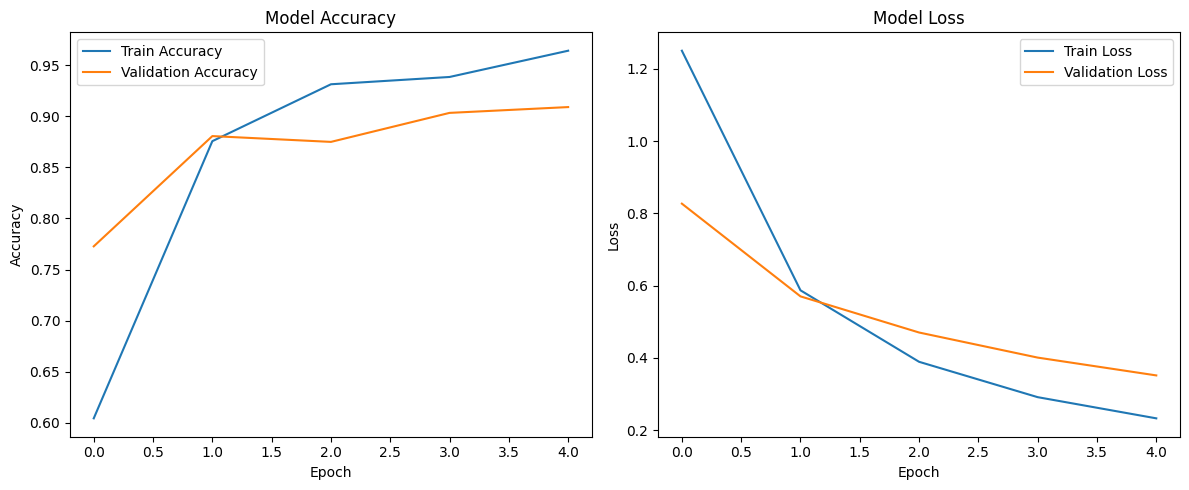

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
model.save("tire_action_model.h5")

In [5]:
from IPython.display import FileLink
FileLink('tire_action_model.h5')


/kaggle/working/tire_action_model.h5

In [11]:
    n_frames=16
    batch_size=2    
    # Load the CSV
    df = pd.read_csv(data_dir / "labels.csv")

    # Split into train/val DataFrames (80% train, 20% val)
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'], 
        random_state=42
    )

    # Create generators
    train_generator = FrameGenerator(
        data_dir=data_dir,
        split_df=train_df,
        n_frames=n_frames,
        training=True  # Enable shuffling
    )

    val_generator = FrameGenerator(
        data_dir=data_dir,
        split_df=val_df,
        n_frames=n_frames,
        training=False  # No shuffling
    )

    # Create TensorFlow datasets
    output_signature = (
        tf.TensorSpec(shape=(n_frames, None, None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
    
    train_ds = tf.data.Dataset.from_generator(
        train_generator,
        output_signature=output_signature
    )
    
    val_ds = tf.data.Dataset.from_generator(
        val_generator,
        output_signature=output_signature
    )

    # Important: drop_remainder=True ensures fixed batch size for XLA compilation
    train_ds = train_ds.batch(batch_size, drop_remainder=True)
    val_ds = val_ds.batch(batch_size, drop_remainder=True)
    
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Build model with fixed input shape
    input_shape = (n_frames, 224, 224, 3)

In [22]:
def save_confusion_matrix(cm, class_names, filename="confusion_matrix.png"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(filename)
    plt.close()

                        precision    recall  f1-score   support

         tighten_bolts       0.86      0.90      0.88        20
    hand_tighten_bolts       0.89      0.85      0.87        20
initial_wrench_tighten       1.00      0.90      0.95        20
    lift_car_with_jack       0.90      0.95      0.93        20
          loosen_bolts       0.95      0.95      0.95        20
             lower_car       0.90      0.90      0.90        20
      place_spare_tire       0.94      0.85      0.89        20
          remove_bolts       0.79      0.94      0.86        16
           remove_tire       1.00      1.00      1.00        20

              accuracy                           0.91       176
             macro avg       0.92      0.92      0.91       176
          weighted avg       0.92      0.91      0.92       176



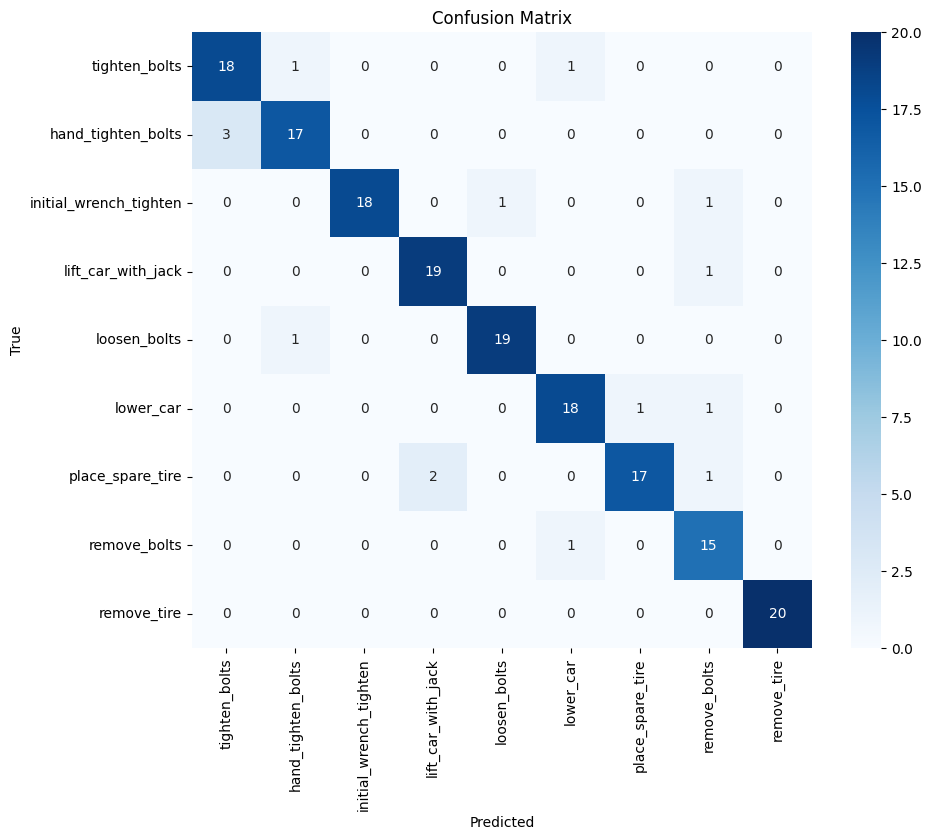

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, val_ds, class_names):
    y_true = []
    y_pred = []

    for videos, labels in val_ds.unbatch():
        preds = model.predict(tf.expand_dims(videos, 0), verbose=0)
        pred_label = tf.argmax(preds, axis=-1).numpy()[0]
        y_true.append(labels.numpy())
        y_pred.append(pred_label)

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    save_confusion_matrix(cm,class_names)

evaluate_model(model, val_ds, train_generator.class_names)


Predicted class: initial_wrench_tighten


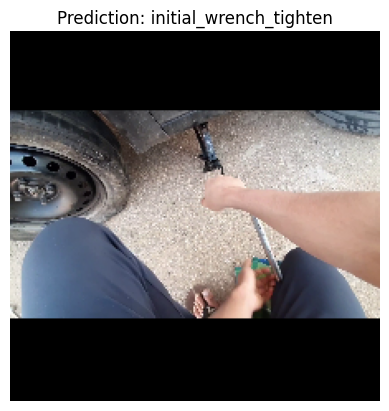

In [20]:
def predict_single_video(model, video_path, n_frames, class_names):
    # Extract frames
    frames = frames_from_video_file(video_path, n_frames)
    frames = tf.convert_to_tensor(frames)
    frames = tf.expand_dims(frames, axis=0)  # Shape: (1, n_frames, 224, 224, 3)
    
    # Predict
    preds = model.predict(frames, verbose=0)
    pred_class = tf.argmax(preds, axis=-1).numpy()[0]
    
    # Display result
    print(f"Predicted class: {class_names[pred_class]}")
    
    # Show first frame
    first_frame = frames[0][0].numpy()
    plt.imshow(first_frame)
    plt.title(f"Prediction: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()

video_path = Path("/kaggle/input/changing-tires/lift_car_with_jack/lift_car_with_jack_25.mp4")
predict_single_video(model, video_path, n_frames=16, class_names=train_generator.class_names)


In [21]:
def save_confusion_matrix(cm, class_names, filename="confusion_matrix.png"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(filename)
    plt.close()


# Upload the the model and evluate it

## Redefine Necessary function

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

# Frame processing functions
def format_frames(frame, output_size=(224, 224)):
    """
    Pad and resize an image from a video.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
    Creates frames from each video file present for each category.
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

class FrameGenerator:
    def __init__(self, data_dir, split_df, n_frames, training=False):
        self.data_dir = Path(data_dir)
        self.split_df = split_df
        self.n_frames = n_frames
        self.training = training
        
        # Extract video paths and labels from DataFrame
        self.video_paths = [self.data_dir / path for path in self.split_df['video_path']]
        self.labels = self.split_df['label'].tolist()
        
        # Extract class names from directory structure (using training data)
        self.class_names = self._get_class_names()

    def _get_class_names(self):
        # Extract directory names from the DataFrame's video paths
        directories = [str(path).split('/')[0] for path in self.split_df['video_path']]
        unique_dirs = sorted(
            set(directories), 
            key=lambda x: self.split_df[self.split_df['video_path'].str.contains(x)].iloc[0]['label']
        )
        return unique_dirs

    def __call__(self):
        pairs = list(zip(self.video_paths, self.labels))
        if self.training:
            random.shuffle(pairs)
        
        for path, label in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            yield video_frames, label


In [8]:
n_frames = 16
batch_size = 8
model_path = '/kaggle/input/3d-cnn-resnet/tire_action_model_3CNN.h5'  # Update this with your actual model path
data_dir = Path("/kaggle/input/changing-tires")  # Adjust if necessary

# Load the saved model
model = tf.keras.models.load_model(model_path)

I0000 00:00:1747767496.215846   14761 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [25]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16, 224, 224, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 16, 224, 224, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 16, 7, 7, 1280)      │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9)                   │          11,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,061,102 (15.49 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2 (12.00 B)

None


In [19]:
# Load the CSV with video paths and labels
df = pd.read_csv(data_dir / "labels.csv")

# Create a test generator using all available data
test_generator = FrameGenerator(
    data_dir=data_dir,
    split_df=df,
    n_frames=n_frames,
    training=False  # No shuffling for reproducible results
)

# Store class names for the confusion matrix
class_names = test_generator.class_names

# Create TensorFlow dataset
output_signature = (
    tf.TensorSpec(shape=(n_frames, None, None, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int16)
)

test_ds = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=output_signature
)

In [20]:
y_true = []
y_pred = []
video_paths = []

# Process each video individually (batch_size=1) to match predictions to files
for frames, label in test_ds.batch(1):
    # Get model prediction
    prediction = model.predict(frames, verbose=0)
    predicted_class = np.argmax(prediction[0])
    
    # Store results
    y_true.append(label.numpy()[0])
    y_pred.append(predicted_class)
    video_paths.append(test_generator.video_paths[len(y_true)-1])

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

In [21]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                        precision    recall  f1-score   support

    hand_tighten_bolts       0.94      0.95      0.95       100
         tighten_bolts       0.97      0.85      0.90       100
initial_wrench_tighten       1.00      0.96      0.98       100
    lift_car_with_jack       0.99      0.96      0.97       100
          loosen_bolts       0.96      0.99      0.98       100
             lower_car       0.99      0.87      0.93       100
      place_spare_tire       0.83      0.98      0.90       100
          remove_bolts       0.96      1.00      0.98        77
           remove_tire       0.94      1.00      0.97       100

              accuracy                           0.95       877
             macro avg       0.95      0.95      0.95       877
          weighted avg       0.95      0.95      0.95       877



In [22]:
# Create a DataFrame with results for deeper analysis
results_df = pd.DataFrame({
    'video_path': [str(path) for path in video_paths],
    'true_label': [class_names[label] for label in y_true],
    'predicted_label': [class_names[pred] for pred in y_pred],
    'correct': [t == p for t, p in zip(y_true, y_pred)]
})

# Save results to CSV
results_df.to_csv('prediction_results.csv', index=False)

# Calculate overall accuracy
accuracy = (results_df['correct'].sum() / len(results_df)) * 100
print(f"Overall accuracy: {accuracy:.2f}%")

# Find misclassified videos
misclassified = results_df[~results_df['correct']]
print(f"Number of misclassified videos: {len(misclassified)}")

if len(misclassified) > 0:
    print("\nSample of misclassified videos:")
    print(misclassified.head(min(5, len(misclassified))))

Overall accuracy: 94.98%
Number of misclassified videos: 44

Sample of misclassified videos:
                                           video_path          true_label  \
0   /kaggle/input/changing-tires/hand_tighten_bolt...  hand_tighten_bolts   
5   /kaggle/input/changing-tires/hand_tighten_bolt...  hand_tighten_bolts   
6   /kaggle/input/changing-tires/hand_tighten_bolt...  hand_tighten_bolts   
56  /kaggle/input/changing-tires/hand_tighten_bolt...  hand_tighten_bolts   
75  /kaggle/input/changing-tires/hand_tighten_bolt...  hand_tighten_bolts   

     predicted_label  correct  
0          lower_car    False  
5   place_spare_tire    False  
6   place_spare_tire    False  
56     tighten_bolts    False  
75     tighten_bolts    False  


# visualise what happen

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

# Function to display frames from a specific video path
def display_video_frames(video_path, n_frames=10, frame_step=15, output_size=(224, 224)):
    """
    Display frames extracted from a video.
    
    Args:
        video_path: Path to the video file
        n_frames: Number of frames to extract
        frame_step: Number of frames to skip between extractions
        output_size: Size to resize frames to
    """
    # Extract frames from the video
    frames = frames_from_video_file(video_path, n_frames, output_size, frame_step)
    
    # Display the frames in a grid
    rows = int(np.ceil(n_frames / 5))
    cols = min(5, n_frames)
    
    plt.figure(figsize=(15, 3 * rows))
    for i in range(n_frames):
        if i >= len(frames):
            break
        plt.subplot(rows, cols, i + 1)
        plt.imshow(frames[i])
        plt.title(f"Frame {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Extracted {len(frames)} frames from {video_path}")
    return frames

# Function to play video with OpenCV
def play_video(video_path):
    """
    Play a video file using OpenCV.
    Press 'q' to quit.
    
    Args:
        video_path: Path to the video file
    """
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    
    print(f"Playing video: {video_path}")
    print("Press 'q' to quit")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Display the frame
        cv2.imshow('Video', frame)
        
        # Press Q to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()



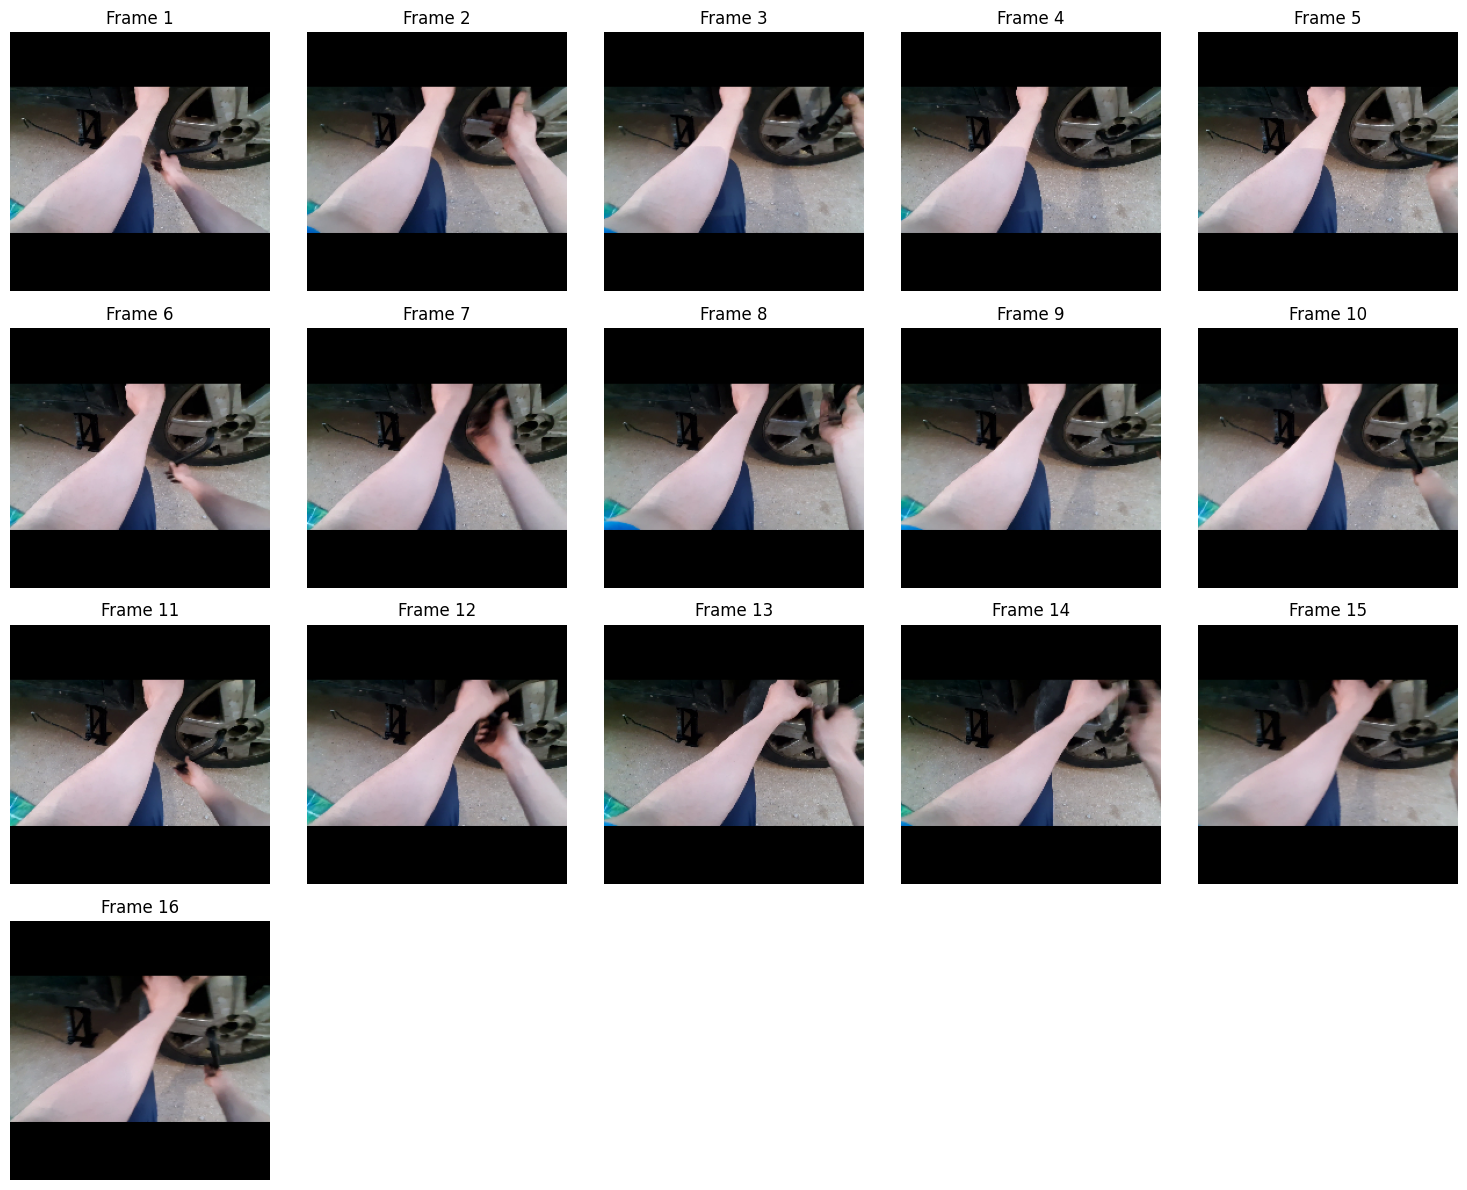

Extracted 16 frames from /kaggle/input/changing-tires/initial_wrench_tighten/initial_wrench_tighten_19.mp4


In [12]:
video_path = "/kaggle/input/changing-tires/initial_wrench_tighten/initial_wrench_tighten_19.mp4"
frames = display_video_frames(video_path, n_frames=16, frame_step=15)


In [ ]:
to_gif(frames)